# **TASK 3**

Submitted By - Tanmay Jain 
 DTU 2nd Year BTECH 
Used Bert for performing the text classification knowing all the maths behind transformers and Bert 
Fine tuning of BERT has been  instead of training entirely scratch which would have given good results 


## Importing the required libraries

In [109]:
#Installing hugging face transformer library 
!pip install transformers

Below code block imports all the required libraries

In [119]:
#importing pytorch 
import torch 
#tqdm for interactive visualization bar
from tqdm.notebook import tqdm 
#BertTokenizer converting input sentence to token using Wordpiece tokenizer
from transformers import BertTokenizer 
#For creating the dataset which is fed to DataLoader which using a sampler provides data in batch without consuming much memory 
from torch.utils.data import TensorDataset 
#BertForSequenceClassification is bert plus one fully connected layer
from transformers import BertForSequenceClassification

#Numpy and Pandas required packages for data manipulation
import numpy as np
import pandas as pd

#matplotlib for visualization
import matplotlib.pyplot as plt

## Reading the dataset

Below code block reads the dataset which I stored in my google drive and displays top 5 rows of the dataset 

In [130]:
#Reading the dataset
data = pd.read_csv("drive/MyDrive/flipkart_dataset.csv")
#Viewing the top 5 rows of dataset
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


## Exploring the dataset with some visualizations

Below code block shows the general information of the dataset 

In [131]:
#Viewing the general data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

Some Visualizations of the null values in every column using seaborn heatmap

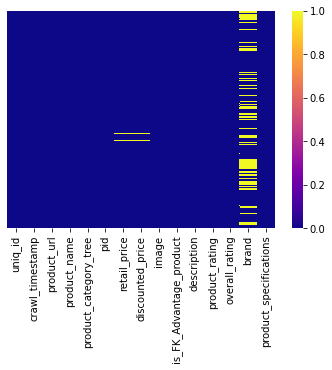

In [132]:
import seaborn as sns
#viewing null values in dataset
sns.heatmap(data.isnull() , yticklabels = False , cmap = "plasma")


Removing all the columns and retaining only the product_category_tree and description 

In [133]:
#Dropping unwanted features from the dataset which wont help in predciting the category of the product 
data = data.drop(["uniq_id" , "crawl_timestamp" , "product_url" ,"pid" , "retail_price" , "discounted_price" , "image" ,"product_specifications", "is_FK_Advantage_product" , "product_rating" , "overall_rating" , "brand" , "product_name"] , axis=1)

In [134]:
#Veiwing data information again 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_category_tree  20000 non-null  object
 1   description            19998 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


As we can see above that description contains rows that are NA , so we drop those rows where description is NA

In [135]:
#Dropping the rows where description is NA 
data = data[data["description"].notna()]


In [136]:
#Viewing the data information again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19998 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_category_tree  19998 non-null  object
 1   description            19998 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


Creating the main category column which is first word of the category tree column and our model will predict this category 

In [137]:
#Creating a main_category column which will be the category predicted by the model 
data['main_category']=data['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])
#viewing the data in classes , we can see classes are imbalanaced
data['main_category'].value_counts()[:200].sort_values(ascending=False)

Clothing                                                6197
Jewellery                                               3531
Footwear                                                1227
Mobiles & Accessories                                   1099
Automotive                                              1012
                                                        ... 
Kraft Seeds Thyme Herbs Seed (200 per packet)"             1
Skayvon SUMMERSIBLE SINGLE PHASE PUMP CONTROLLER..."       1
Carbanao Chrome Grill Chevrolet Cruze Car Grill ..."       1
Speedwav 186879 Bajaj Pulsar 200 NS DTS-i LED In..."       1
Himmlisch 20503 Car Bottle Holder (Plastic)"               1
Name: main_category, Length: 200, dtype: int64

Getting all the unique categories in the main_category column

In [138]:
possible_labels = data.main_category.unique()
#getting all possible prodcut labels
print(possible_labels)

['Clothing' 'Furniture' 'Footwear' 'Pet Supplies'
 'Eternal Gandhi Super Series Crystal Paper Weight..."'
 'Pens & Stationery' 'Sports & Fitness' 'Beauty and Personal Care'
 'Bengal Blooms Rose Artificial Plant  with Pot (3..."'
 'Bags, Wallets & Belts' 'Home Decor & Festive Needs' 'Automotive'
 'Tools & Hardware' 'Vishudh Printed Women\'s Straight Kurta"'
 'Vishudh Printed Women\'s Anarkali Kurta"'
 'BuildTrack PIR Wireless Motion Sensor - One Swit..."'
 'Skayvon SUMMERSIBLE SINGLE PHASE PUMP CONTROLLER..."'
 'MASARA Solid Women\'s Straight Kurta"'
 'Skayvon SUBMERSIBBLE THREE PHASE PUMP CONTROLLER..."'
 'Behringer Xenyx 502 Analog Sound Mixer"'
 'Noor Embroidered Women\'s Straight Kurta"'
 'Libas Printed Women\'s A-line Kurta"'
 'Libas Printed Women\'s Anarkali Kurta"' 'Home Furnishing' 'Baby Care'
 'Mobiles & Accessories' 'Food & Nutrition' 'Watches'
 'Toys & School Supplies' 'Jewellery'
 'Cellbazaar Blackberry 8520 WHITE LCD LCD (YIT-562)"'
 'Dressberry Gold Synthetic  Clutch"'
 'M

Removing the categories where the occurrence of the category is less than 9 (Which is selected after some experiments)

In [139]:
#removing product categories where occurence is less than 1 
data = data[data["main_category"].map(data['main_category'].value_counts()) > 9]

Visualizing the category count using bar graphs

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


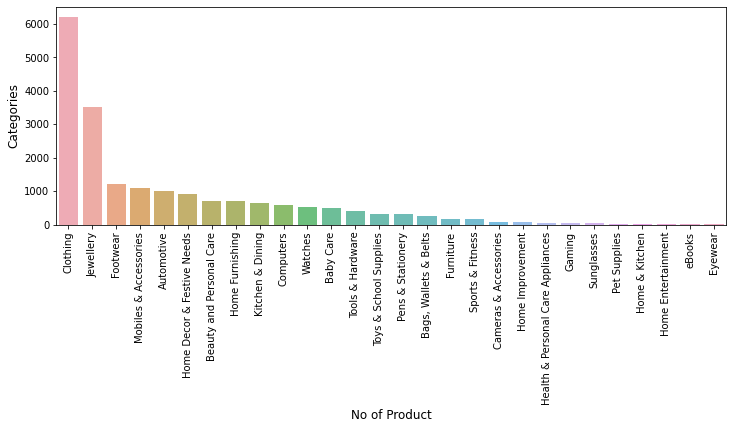

In [140]:
cnt_pro = data["main_category"].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Categories', fontsize=12)
plt.xlabel('No of Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

We can see from below that the data classes are imbalanced

In [141]:
data["main_category"].value_counts()

Clothing                             6197
Jewellery                            3531
Footwear                             1227
Mobiles & Accessories                1099
Automotive                           1012
Home Decor & Festive Needs            929
Beauty and Personal Care              710
Home Furnishing                       699
Kitchen & Dining                      647
Computers                             578
Watches                               530
Baby Care                             483
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     313
Bags, Wallets & Belts                 265
Furniture                             180
Sports & Fitness                      166
Cameras & Accessories                  82
Home Improvement                       81
Health & Personal Care Appliances      43
Gaming                                 35
Sunglasses                             35
Pet Supplies                      

Getting the possible labels which are possible for each description 

In [142]:
possible_labels = data.main_category.unique()
#getting all possible prodcut labels
print(possible_labels)

['Clothing' 'Furniture' 'Footwear' 'Pet Supplies' 'Pens & Stationery'
 'Sports & Fitness' 'Beauty and Personal Care' 'Bags, Wallets & Belts'
 'Home Decor & Festive Needs' 'Automotive' 'Tools & Hardware'
 'Home Furnishing' 'Baby Care' 'Mobiles & Accessories' 'Watches'
 'Toys & School Supplies' 'Jewellery' 'Kitchen & Dining' 'Home & Kitchen'
 'Computers' 'Cameras & Accessories' 'Health & Personal Care Appliances'
 'Gaming' 'Home Improvement' 'Sunglasses' 'Home Entertainment' 'Eyewear'
 'eBooks']


In [143]:
# Veiwing the information for the dataset again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19661 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_category_tree  19661 non-null  object
 1   description            19661 non-null  object
 2   main_category          19661 non-null  object
dtypes: object(3)
memory usage: 614.4+ KB


Encoding the labels of the text using a dictionary 

In [144]:
#encoding the labels
label_dict = {}
for index , possible_label in enumerate(possible_labels):
  label_dict[possible_label] =  index

print(label_dict)

{'Clothing': 0, 'Furniture': 1, 'Footwear': 2, 'Pet Supplies': 3, 'Pens & Stationery': 4, 'Sports & Fitness': 5, 'Beauty and Personal Care': 6, 'Bags, Wallets & Belts': 7, 'Home Decor & Festive Needs': 8, 'Automotive': 9, 'Tools & Hardware': 10, 'Home Furnishing': 11, 'Baby Care': 12, 'Mobiles & Accessories': 13, 'Watches': 14, 'Toys & School Supplies': 15, 'Jewellery': 16, 'Kitchen & Dining': 17, 'Home & Kitchen': 18, 'Computers': 19, 'Cameras & Accessories': 20, 'Health & Personal Care Appliances': 21, 'Gaming': 22, 'Home Improvement': 23, 'Sunglasses': 24, 'Home Entertainment': 25, 'Eyewear': 26, 'eBooks': 27}


Creating the label column for the dataset which gives same output as label encoding

In [145]:
data["label"] = data.main_category.replace(label_dict)

## Spliting the data into training and validation set

Visualizing the data with groupby and getting training and validation set number of rows for each classes

In [146]:
from sklearn.model_selection import train_test_split 

X_train , X_val , Y_train , Y_val = train_test_split(data.index.values, data.label.values, test_size = 0.1 , random_state=42 , stratify = data.label.values)
data["data_type"] = ['not_set'] * data.shape[0]
data.loc[X_train , 'data_type'] = 'train'
data.loc[X_val , 'data_type'] = 'val'

#Grouping by Main_category , Category_label , Data_type
data.groupby(["main_category" , "label" , "data_type"]).count()

product_category_tree  description
main_category                     label data_type                                    
Automotive                        9     train                        911          911
                                        val                          101          101
Baby Care                         12    train                        435          435
                                        val                           48           48
Bags, Wallets & Belts             7     train                        238          238
                                        val                           27           27
Beauty and Personal Care          6     train                        639          639
                                        val                           71           71
Cameras & Accessories             20    train                         74           74
                                        val                            8            8
Clothing                          0     train                       5577         5577
                                        val                          620          620
Computers                         19    train                        520          520
                                        val                           58           58
Eyewear                           26    train                          9            9
                                        val                            1            1
Footwear                          2     train                       1104         1104
                                        val                          123          123
Furniture                         1     train                        162          162
                                        val                           18           18
Gaming                            22    train                         31           31
                                        val                            4            4
Health & Personal Care Appliances 21    train                         39           39
                                        val                            4            4
Home & Kitchen                    18    train                         22           22
                                        val                            2            2
Home Decor & Festive Needs        8     train                        836          836
                                        val                           93           93
Home Entertainment                25    train                         17           17
                                        val                            2            2
Home Furnishing                   11    train                        629          629
                                        val                           70           70
Home Improvement                  23    train                         73           73
                                        val                            8            8
Jewellery                         16    train                       3178         3178
                                        val                          353          353
Kitchen & Dining                  17    train                        582          582
                                        val                           65           65
Mobiles & Accessories             13    train                        989          989
                                        val                          110          110
Pens & Stationery                 4     train                        282          282
                                        val                           31           31
Pet Supplies                      3     train                         27           27
                                        val                            3            3
Sports & Fitness                  5     train                        149          149
         

## Started using the BERT by importing the tokenizer 

In [147]:
#Bert tokenizer = Tokenization is process to take raw text to split into tokens
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased" , do_lower_case = True)
#To convert the description to tokenized form using batch_encode_plus 
encoded_data_train = tokenizer.batch_encode_plus(data[data.data_type=="train"].description.values , 
                                                 add_special_tokens = True, return_attention_mask = True ,pad_to_max_length =True , max_length = 450 , return_tensors="pt" )
encoded_data_val = tokenizer.batch_encode_plus(data[data.data_type=="val"].description.values , 
                                                 add_special_tokens = True, return_attention_mask = True ,pad_to_max_length =True , max_length = 450 , return_tensors="pt" )


#inputs ids for train and validation with the attention mask with the labels
input_ids_train = encoded_data_train["input_ids"]
attention_masks_train = encoded_data_train["attention_mask"]
labels_train = torch.tensor(data[data.data_type=="train"].label.values)

input_ids_val = encoded_data_val["input_ids"]
attention_masks_val = encoded_data_val["attention_mask"]
labels_val = torch.tensor(data[data.data_type=="val"].label.values)


#Creating the training dataset
dataset_train = TensorDataset(input_ids_train , attention_masks_train , labels_train)
dataset_val = TensorDataset(input_ids_val , attention_masks_val , labels_val)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Loading the pretrained BERT for sequence classification , which is normal bert plus one fully connected layer 

In [148]:

#Loading the bert pretrained model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased" , num_labels = len(label_dict) , output_attentions=False , output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Making the dataloader for feeding the data into network 


In [149]:
#DataLoader combines dataset and sampler and provides iterable over dataset 
from torch.utils.data import DataLoader , RandomSampler , SequentialSampler

#Setting the batch_Size 
batch_size = 10

# Making the dataloader 
dataloader_train = DataLoader(dataset_train , sampler=RandomSampler(dataset_train) , batch_size = batch_size)

#Making validation dataloader 
dataloader_validation = DataLoader(dataset_val  , sampler = SequentialSampler(dataset_val) , batch_size = batch_size)


In [150]:
#Learning rate warmup increases learning rate intially at a linear rate and then then it decreases linearly to 0 
from transformers import AdamW , get_linear_schedule_with_warmup 

optimizer = AdamW(model.parameters() , lr = 1e-5 , eps = 1e-8)
epochs = 4

# Warmup increases learning rate linearly from 0 to some value then the rate also decreases linearly
scheduler = get_linear_schedule_with_warmup(optimizer , num_warmup_steps = 8 , num_training_steps = len(dataloader_train)* epochs)

In [151]:
# Importing the f1_score calculator from sklearn
from sklearn.metrics import f1_score 

Creating the f1_score_function to get the F1score and getting accuracy per class

In [154]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Now , finally training the model , model was trained on 4 epochs 
 ## The model was trained 5 times which took a lots of time just for training the BERT

In [ ]:
import random


seed_val = 17
random.seed(seed_val)

np.random.seed(seed_val)
torch.manual_seed(seed_val)

torch.cuda.manual_seed_all(seed_val)

device = "cuda:0"
model = model.to(device)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


for epoch in tqdm(range(1, epochs + 1)):
  model.train()
  loss_train_total = 0 
  progress_bar = tqdm(dataloader_train , desc="Epoch {:1d}".format(epoch) , leave=False,disable=False )
  for batch in progress_bar:
    #setting intial grad to zeros
    model.zero_grad()
    batch = tuple(b.to(device) for b in batch )
    inputs = {"input_ids" : batch[0] , "attention_mask" : batch[1] , "labels" : batch[2]}
    outputs = model(**inputs)
    loss = outputs[0]
    loss_train_total += loss.item()
    loss.backward()
    #Prevent gradient from exploding
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
  torch.save(model.state_dict(), f'drive/MyDrive/BERT_final_epoch_{epoch}.model')
        
  tqdm.write(f'\nEpoch {epoch}')
    
  loss_train_avg = loss_train_total/len(dataloader_train)            
  tqdm.write(f'Training loss: {loss_train_avg}')
  val_loss, predictions, true_vals = evaluate(dataloader_validation)
  val_f1 = f1_score_func(predictions, true_vals)
  tqdm.write(f'Validation loss: {val_loss}')
  tqdm.write(f'F1 Score (Weighted): {val_f1}')




## Testing our dataset on the validation set calculating the accuracy per class

In [155]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
device = "cuda:0"

model.to(device)

model.load_state_dict(torch.load('drive/MyDrive/BERT_final_epoch_4.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Clothing
Accuracy: 615/620

Class: Furniture
Accuracy: 17/18

Class: Footwear
Accuracy: 123/123

Class: Pet Supplies
Accuracy: 2/3

Class: Pens & Stationery
Accuracy: 19/31

Class: Sports & Fitness
Accuracy: 15/17

Class: Beauty and Personal Care
Accuracy: 70/71

Class: Bags, Wallets & Belts
Accuracy: 26/27

Class: Home Decor & Festive Needs
Accuracy: 93/93

Class: Automotive
Accuracy: 101/101

Class: Tools & Hardware
Accuracy: 39/39

Class: Home Furnishing
Accuracy: 70/70

Class: Baby Care
Accuracy: 40/48

Class: Mobiles & Accessories
Accuracy: 106/110

Class: Watches
Accuracy: 53/53

Class: Toys & School Supplies
Accuracy: 29/33

Class: Jewellery
Accuracy: 352/353

Class: Kitchen & Dining
Accuracy: 64/65

Class: Home & Kitchen
Accuracy: 0/2

Class: Computers
Accuracy: 57/58

Class: Cameras & Accessories
Accuracy: 8/8

Class: Health & Personal Care Appliances
Accuracy: 3/4

Class: Gaming
Accuracy: 3/4

Class: Home Improvement
Accuracy: 7/8

Class: Sunglasses
Accuracy: 4/4

Clas